# Uso Avançado de RNN

> **3 Técnicas** para melhorar o desempenho e o poder de generalização das RNN:

- *Recurrent dropout*: para cobater overfitting
- *Stacking recurrent layers*: para aumentar o poder representacional da rede
- *Bidirectional recurrent layers*: apresentar a mesma informação para redes diferentes, aumentando a acurácia e mitigando problemas.

## Case: Previsão de temperatura
Diferente dos casos anteriores, em que analisamos sequência de texto, iremos trabalhar agora com séries temporais, outra aplicação de deep learning para sequências.





In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
data_dir = '/content/drive/My Drive/Deep_Learning/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [0]:
# Abrindo o arquivo
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Precisamos converter o arquivo em um array do Numpy

In [0]:
import numpy as np

#criando uma matriz de zeros
float_data = np.zeros((len(lines), len(header) - 1))

#preenchendo com os dados do dataset
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Plotando a temperatura ao longo do tempo (*timeseries*)

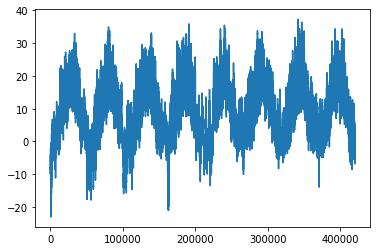

In [0]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

Visualizando apenas os 10 primeiros dias:

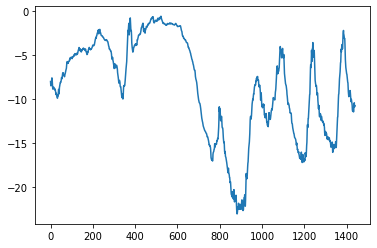

In [0]:
plt.plot(range(1440), temp[:1440])

- As temperaturas possuem boa periodicidade quando olhamos anualmente.
- Entretanto, a coisa fica mais caótica quando olhamos diariamente, sendo mais complexo prever a temperatura de um dia do que de um mês.

### Preparação dos dados
> Settings:
1. lookback = 720—Observations will go back 5 days.
2. steps = 6—Observations will be sampled at one data point per hour.
3. delay = 144—Targets will be 24 hours in the future.

Precisamos:
- normalizar os dados: $\frac{x-\bar{x}}{\sigma_x}$
- fazer batches dos dados

In [0]:
# Preparando os dados
# usando apenas os 200000 primeiros dados para a média e o desvio padrão

mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

Precisamos fazer uma *feature engineering* e obter as seguintes variáveis:

- **data** —The original array of floating-point data, which you normalized in listing 6.32.
- **lookback** —How many timesteps back the input data should go.
- **delay** —How many timesteps in the future the target should be.
- **min_index** and **max_index** —Indices in the data array that delimit which timesteps
to draw from. This is useful for keeping a segment of the data for validation
and another for testing.
- **shuffle** —Whether to shuffle the samples or draw them in chronological order.
- **batch_size** —The number of samples per batch.
- **step** —The period, in timesteps, at which you sample data. You’ll set it to 6 in
order to draw one data point every hour.

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Com a função *generator* iremos selecionar as amostras de treino, validação e teste. As seleções de validação e teste serão *out of time*, ou seja, em períodos posteriores.

In [0]:
#setting das constantes
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# Garantindo que a amostra de validação seja feita no batch subsequente à amostra de treino
val_steps = (300000 - 200001 - lookback) // batch_size

# Garantindo que a amostra de teste seja feita no batch subsequente à amostra de validação
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### Baseline e Sanity Check
É sempre importante termos uma baseline para compararmos os resultados e fazermos um *sanity check*.

No caso da previsão de tempo, podemos assumir que:
- as temperaturas são contínuas.
- a temperatura em 24h será a mesma que agora.

Para avaliar esse baseline, usamos o erro absoluto médio (MAE).

In [0]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


> Considerando que fizemos a normalização dos dados, temos:
$0.29 \times \sigma_{Temperature} = 2.57^o C$

Temos que fazer uma previsão cujo MAE seja menor!

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Using TensorFlow backend.









Epoch 1/20





500/500 [==============================] - 13s 26ms/step - loss: 1.6248 - val_loss: 1.7177
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 2.5672 - val_loss: 5.1858
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 5.5524 - val_loss: 8.4540
Epoch 4/20
500/500 [==============================] - 13s 26ms/step - loss: 9.3855 - val_loss: 10.1728
Epoch 5/20
500/500 [==============================] - 13s 25ms/step - loss: 14.1595 - val_loss: 16.8647
Epoch 6/20
500/500 [==============================] - 13s 25ms/step - loss: 18.9023 - val_loss: 24.4707
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 23.9287 - val_loss: 30.2016
Epoch 8/20
500/500 [==============================] - 13s 25ms/step - loss: 28.8016 - val_loss: 29.5478
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 33.7740 - val_loss: 55.5294
Epoch 10/20
500/500 [==============================] - 13s 

In [0]:
evaluate_naive_method()

ValueError: ignored

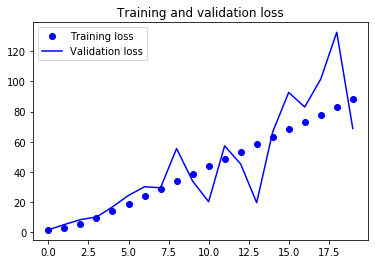

In [0]:
# Visualização dos resultados
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- Nesse treino, utilizamos a sequência de dados como um todo, sem considerar como cada medida T em um tempo t influência o a temperatura T+1.

- Da mesma maneira que com a sequência de palavras no review, a ordem e a causalidade importante!

> Uilizaremos uma **GRU** (***gated recurrent unit***, "unidade recorrente fechada"), que são similares a LSTM, mas são mais baratas computacionalmente.

### Baseline recorrente - uma primeira tentativa

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
500/500 [==============================] - 114s 229ms/step - loss: 0.3119 - val_loss: 0.2720
Epoch 2/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2854 - val_loss: 0.2676
Epoch 3/20
500/500 [==============================] - 113s 227ms/step - loss: 0.2783 - val_loss: 0.2615
Epoch 4/20
500/500 [==============================] - 113s 227ms/step - loss: 0.2733 - val_loss: 0.2721
Epoch 5/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2662 - val_loss: 0.2637
Epoch 6/20
500/500 [==============================] - 112s 224ms/step - loss: 0.2587 - val_loss: 0.2695
Epoch 7/20
500/500 [==============================] - 112s 225ms/step - loss: 0.2538 - val_loss: 0.2691
Epoch 8/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2502 - val_loss: 0.2699
Epoch 9/20
500/500 [==============================] - 113s 226ms/step - lo

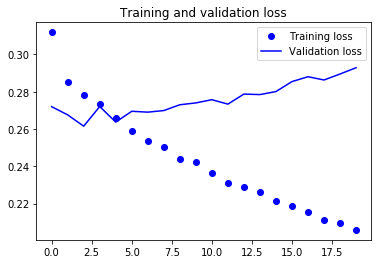

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


## Dropout para evitar overfitting

Para evitar o **overfitting** usar o dropout é uma boa opção, uma vez que ele 'quebra' algumas correlações entre os dados de treinamento, evitando o superajuste.

> Fazer isso em redes recorrentes não é trivial, pois necessitamos das informações prévias para o treinamento recorrente.

**Yarin Gal**: a máscara de dropout deve ser *a mesma em todos os timesteps*. Uma máscara de dropout constante deve ser aplicada às ativações internas da camada recorrente, numa espécie de "***dropout recorrente***".

No Keras, cada camada recorrente pode ter dois argumentos de dropout:
- dropout, um valor decimal que diz a taxa de dropout para as unidades de input da camada
- recurrent_dropout, que especifica a taxa de dropout das unidades recorrentes.



In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 133s 266ms/step - loss: 0.3326 - val_loss: 0.2759
Epoch 2/40
500/500 [==============================] - 132s 265ms/step - loss: 0.3143 - val_loss: 0.2760
Epoch 3/40
500/500 [==============================] - 131s 262ms/step - loss: 0.3074 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 131s 262ms/step - loss: 0.3029 - val_loss: 0.2727
Epoch 5/40
500/500 [==============================] - 132s 265ms/step - loss: 0.3019 - val_loss: 0.2699
Epoch 6/40
500/500 [==============================] - 133s 266ms/step - loss: 0.2993 - val_loss: 0.2680
Epoch 7/40
500/500 [==============================] - 133s 266ms/step - loss: 0.2956 - val_loss: 0.2676
Epoch 8/40
500/500 [==============================] - 133s 267ms/step - loss: 0.2924 - val_loss: 0.2670
Epoch 9/40
500/500 [==============================] 

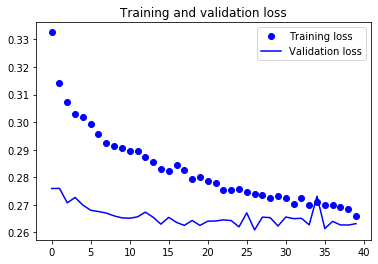

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Empilhando Camadas Recorrentes

bla bla

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 341s 681ms/step - loss: 0.3336 - val_loss: 0.2745
Epoch 2/40
500/500 [==============================] - 338s 675ms/step - loss: 0.3144 - val_loss: 0.2722
Epoch 3/40
500/500 [==============================] - 341s 683ms/step - loss: 0.3068 - val_loss: 0.2724
Epoch 4/40
500/500 [==============================] - 339s 678ms/step - loss: 0.3012 - val_loss: 0.2697
Epoch 5/40
500/500 [==============================] - 339s 678ms/step - loss: 0.2969 - val_loss: 0.2646
Epoch 6/40
500/500 [==============================] - 339s 678ms/step - loss: 0.2952 - val_loss: 0.2710
Epoch 7/40
500/500 [==============================] - 338s 676ms/step - loss: 0.2924 - val_loss: 0.2675
Epoch 8/40
500/500 [==============================] - 339s 677ms/step - loss: 0.2894 - val_loss: 0.2626
Epoch 9/40
500/500 [==============================] - 338s 675ms/step - loss: 0.2856 - val_loss: 0.2641
Epoch 10/40
500/500 [==============================] - 338s 677m

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Camadas Bidirecionais

bla bla bla

In [0]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [0]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#bla
 bla bla

In [0]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

# blas
msdklfsdkjmf
kdsjfndz
kndfmzdx

In [0]:
from keras import backend as K
K.clear_session()

In [0]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

# ndsklfdsz
dskjfjsd,z
kjdjsfnds

In [0]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# mais blas

escritos

e descritos